In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1.loads data from the original source on the web
def load_data(url: str) -> pd.DataFrame:
    """Load dataset from a given URL."""
    return pd.read_csv(url)

# 2. wrangles and cleans the data from it’s original (downloaded) format to the format necessary for the planned classification or clustering analysis
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean dataset: remove duplicates, handle missing values."""
    df = df.drop_duplicates()

    # Handle missing values
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
    df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

    return df

url = "https://github.com/manthangandhi/hotel_cancellation_prediction/raw/refs/heads/main/data/hotel_bookings.csv"
df = load_data(url)
df_clean = clean_data(df)

/var/folders/rv/7txrlwz97ln_0fl__lh05xbm0000gv/T/ipykernel_6570/210987562.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
/var/folders/rv/7txrlwz97ln_0fl__lh05xbm0000gv/T/ipykernel_6570/210987562.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))


In [2]:
# 3. performs a summary of the data set that is relevant for exploratory data analysis related to the planned classification analysis
def summarize_data(df: pd.DataFrame) -> None:
    """Print summary of dataset for EDA."""
    print("\n=== Dataset Summary ===")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

    print("\n--- DataFrame Info ---")
    df.info()

    print("\n--- Target Variable Distribution (is_canceled) ---")
    print(df['is_canceled'].value_counts(normalize=True).rename("proportion").to_frame())

    print("\n--- Numerical Features Summary ---")
    print(df.describe().T[['mean', 'std', 'min', 'max']])

    print("\n--- Categorical Features Summary ---")
    print(df.describe(include='object').T[['unique', 'top', 'freq']])

    print("\n--- Missing Values After Cleaning ---")
    print(pd.DataFrame({"Metric": ["Total Missing"], "Count": [df.isnull().sum().sum()]}))

summarize_data(df_clean)


=== Dataset Summary ===
Shape: 87396 rows × 32 columns

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 87396 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87396 non-null  object 
 1   is_canceled                     87396 non-null  int64  
 2   lead_time                       87396 non-null  int64  
 3   arrival_date_year               87396 non-null  int64  
 4   arrival_date_month              87396 non-null  object 
 5   arrival_date_week_number        87396 non-null  int64  
 6   arrival_date_day_of_month       87396 non-null  int64  
 7   stays_in_weekend_nights         87396 non-null  int64  
 8   stays_in_week_nights            87396 non-null  int64  
 9   adults                          87396 non-null  int64  
 10  children                        87396 non-null  float64
 11  babies           

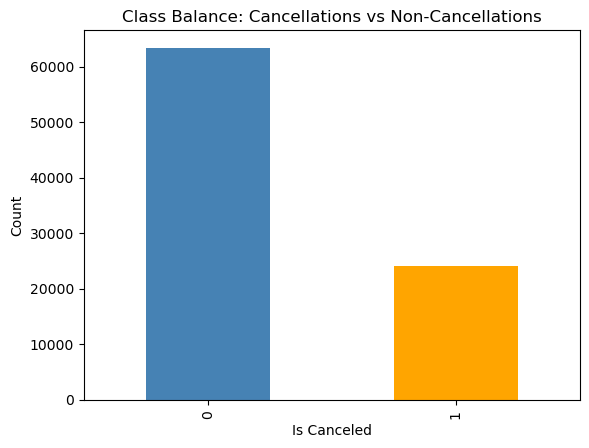

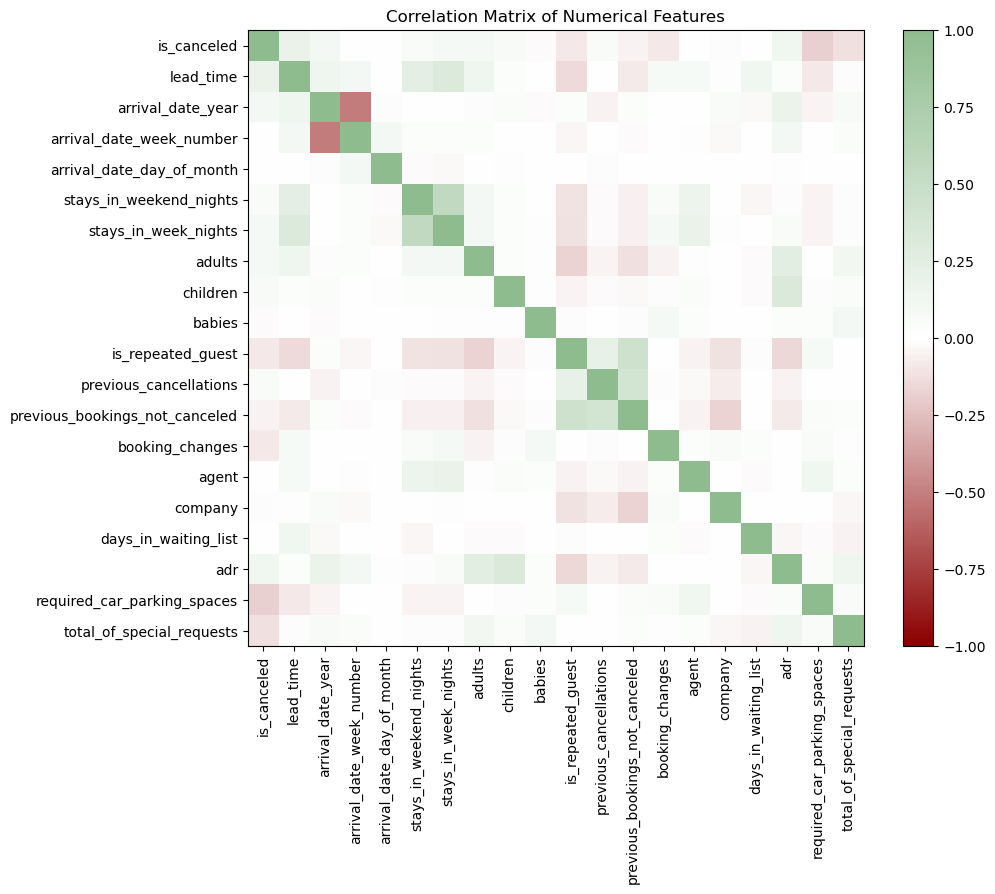

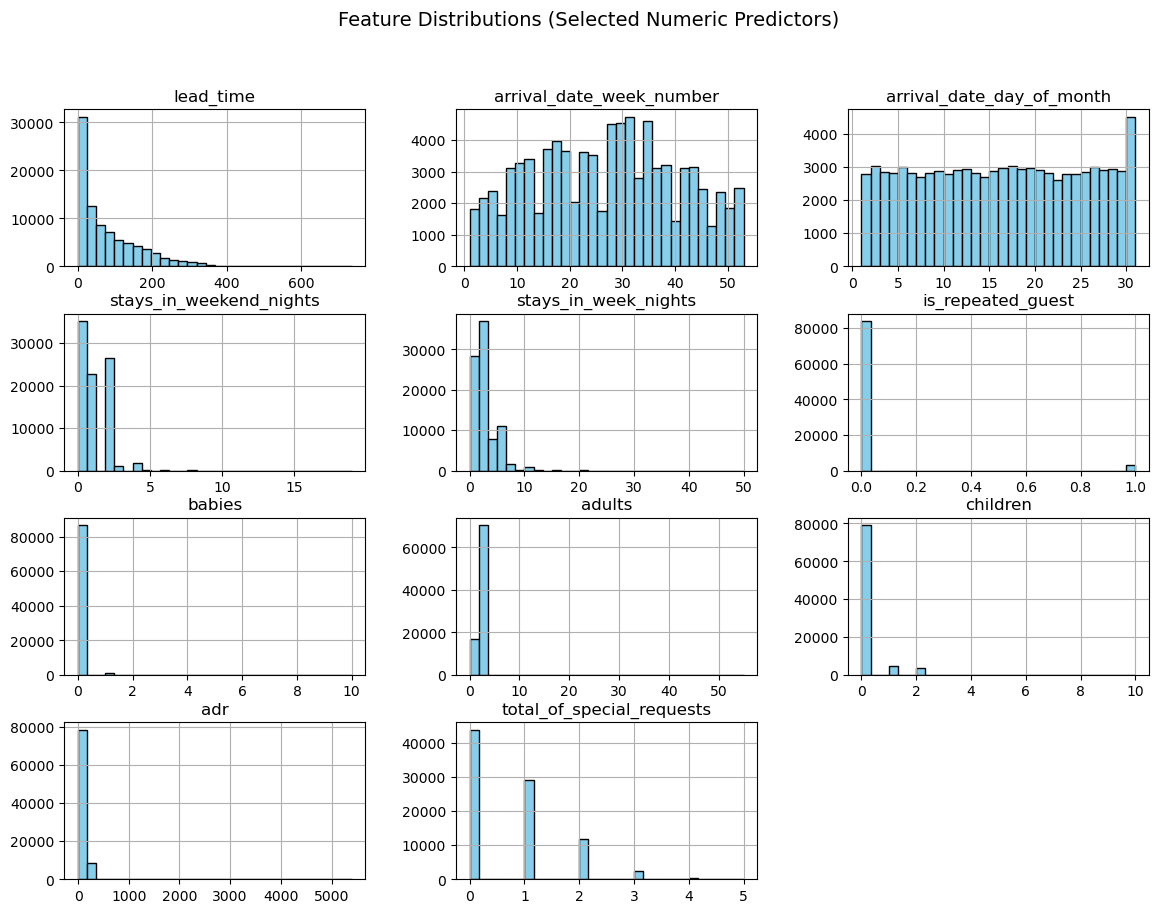

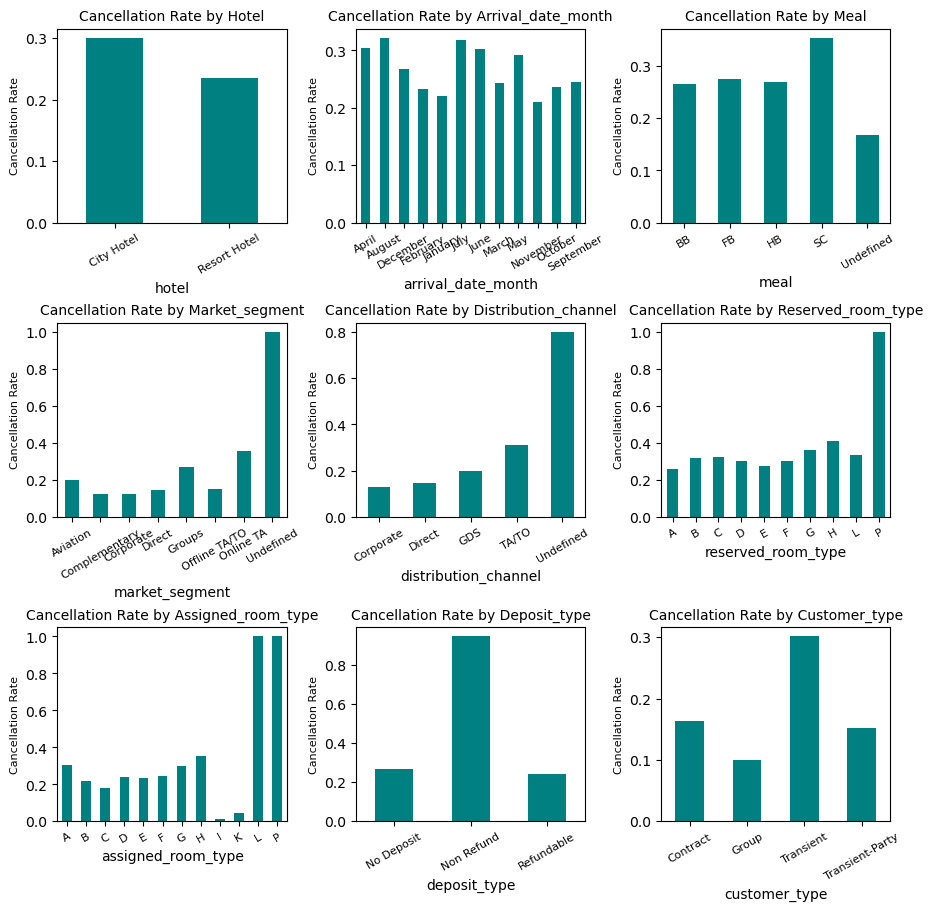

In [5]:
def visualize_data(df: pd.DataFrame) -> None:
    """Generate key EDA plots using matplotlib."""

    # 1. Class balance check
    df['is_canceled'].value_counts().plot(
        kind='bar',
        color=['steelblue', 'orange'],
        title="Class Balance: Cancellations vs Non-Cancellations"
    )
    plt.xlabel("Is Canceled")
    plt.ylabel("Count")
    plt.show()

    # 2. Correlation matrix (some numerical features only)
    import matplotlib.colors as mcolors
    
    plt.figure(figsize=(10, 8))
    corr = df.select_dtypes(include=['int64', 'float64']).corr()
    
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "custom_diverging",
        ["darkred", "white", "darkseagreen"]
    )
    
    plt.imshow(corr, cmap=cmap, interpolation='nearest', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()

    # 3. Feature distributions (some numeric predictors)
    numeric_features = [
        'lead_time',
        'arrival_date_week_number',
        'arrival_date_day_of_month',
        'stays_in_weekend_nights',
        'stays_in_week_nights',
        'is_repeated_guest',
        'babies',
        'adults',
        'children',
        'adr',
        'total_of_special_requests'
    ]
    df[numeric_features].hist(bins=30, figsize=(14, 10), color='skyblue', edgecolor='black')
    plt.suptitle("Feature Distributions (Selected Numeric Predictors)", fontsize=14)
    plt.show()

    # 4. Categorical breakdowns (excluding reservation_status_date, reservation_status, country)
    categorical_features = df.select_dtypes(include=['object']).columns
    categorical_features = [f for f in categorical_features if f not in 
                            ['reservation_status_date', 'reservation_status', 'country']]
    
    # for feature in categorical_features:
    #     cancel_rate = df.groupby(feature)['is_canceled'].mean()
    #     cancel_rate.plot(kind='bar', color='teal', title=f"Cancellation Rate by {feature.capitalize()}")
    #     plt.ylabel("Cancellation Rate")
    #     plt.xticks(rotation=30)
    #     plt.show()

    fig, axes = plt.subplots(3, 3, figsize=(9, 9), constrained_layout=True)
    axes = axes.flatten()
    
    for ax, feature in zip(axes, categorical_features):
        cancel_rate = df.groupby(feature)['is_canceled'].mean()
        cancel_rate.plot(kind='bar', color='teal', ax=ax)
        ax.set_title(f"Cancellation Rate by {feature.capitalize()}", fontsize=10)
        ax.set_ylabel("Cancellation Rate", fontsize=8)
        ax.tick_params(axis='x', rotation=30, labelsize=8)
    
    plt.show()

visualize_data(df_clean)

# def main():
#     url = "https://github.com/manthangandhi/hotel_cancellation_prediction/raw/refs/heads/main/data/hotel_bookings.csv"
#     df = load_data(url)
#     df_clean = clean_data(df)
#     summarize_data(df_clean)
#     visualize_data(df_clean)
#
# if __name__ == "__main__":
#     main()

In [2]:
import pandas as pd
import altair as alt
alt.data_transformers.enable("default")
alt.data_transformers.disable_max_rows()
alt.renderers.enable('png')

RendererRegistry.enable('png')

## Question of Interest: 
Can we predict hotel cancellations from booking lead time and different types of guest behaviors, using hotel booking information from the year 2017? And do cancellations differ across hotel type?


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/manthangandhi/hotel_cancellation_prediction/refs/heads/main/data/hotel_bookings.csv')

## Feature Selection

In [4]:
cols_of_interest = [
    "hotel",
    "arrival_date_year",
    "is_canceled", 
    "lead_time",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "total_of_special_requests",
    "is_repeated_guest",
    "deposit_type",
    "reserved_room_type"
]

hotel_data = data[cols_of_interest]

In [5]:
hotel_data.columns.to_list()

['hotel',
 'arrival_date_year',
 'is_canceled',
 'lead_time',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'total_of_special_requests',
 'is_repeated_guest',
 'deposit_type',
 'reserved_room_type']

In [6]:
hotel_data['arrival_date_year'].value_counts()

arrival_date_year
2016    56707
2017    40687
2015    21996
Name: count, dtype: int64

Since the entire dataset is quite large, we'll be focusing on hotel data from the most recent year, the year 2017, to make predictions about hotel cancellations.

In [7]:
data_2017 = hotel_data[hotel_data['arrival_date_year'] == 2017]

In [8]:
#now that we don't need the year column, we can drop it. 
hotel_data_cleaned = data_2017.drop(columns=['arrival_date_year']).dropna()
hotel_data_cleaned

,hotel,is_canceled,lead_time,previous_cancellations,previous_bookings_not_canceled,booking_changes,total_of_special_requests,is_repeated_guest,deposit_type,reserved_room_type
9775,Resort Hotel,1,74,0,0,0,0,0,No Deposit,A
9776,Resort Hotel,1,62,0,0,0,1,0,No Deposit,A
9777,Resort Hotel,1,62,0,0,0,1,0,No Deposit,A
9778,Resort Hotel,1,62,0,0,0,1,0,No Deposit,A
9779,Resort Hotel,1,71,0,0,0,1,0,No Deposit,A
...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,0,0,0,0,0,No Deposit,A
119386,City Hotel,0,102,0,0,0,2,0,No Deposit,E
119387,City Hotel,0,34,0,0,0,4,0,No Deposit,D
119388,City Hotel,0,109,0,0,0,0,0,No Deposit,A


## EDA

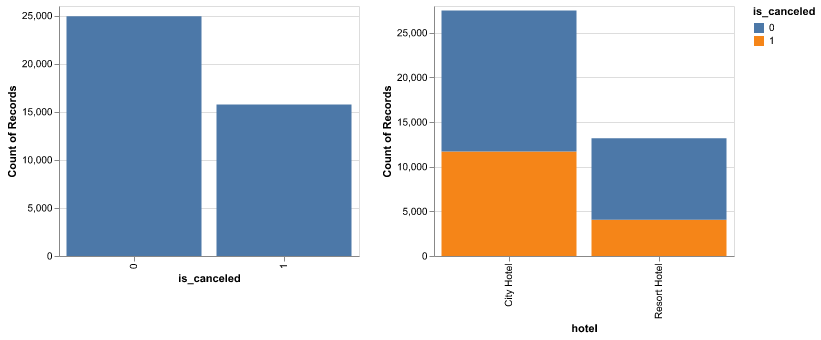

In [9]:
target_dist = alt.Chart(hotel_data_cleaned[['is_canceled', 'hotel']]).mark_bar().encode(
    x='is_canceled:N',
    y='count()',
).properties(
    height=250, 
    width=300
)

target_dist_hotel_type = alt.Chart(hotel_data_cleaned).mark_bar().encode(
    x='hotel:N',
    y='count()',
    color='is_canceled:N'
).properties(
    height=250, 
    width=300
)

target_dist | target_dist_hotel_type

As we can see from the plot on the left, there is not a significant class imbalance. The number of cancellations is slightly lower than the number of non cancellations, however, the proportion of cancellations to non cancellations is not extremely different.

The plot on the right shows that there are more cancellations for city hotels compared to resort hotels.

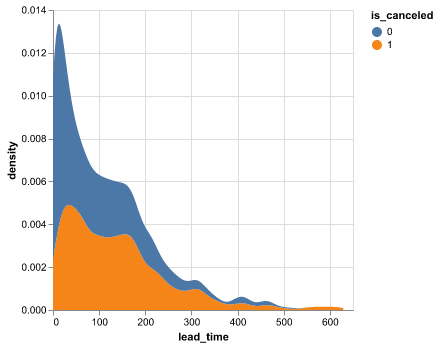

In [10]:
lead_time_plot = alt.Chart(hotel_data_cleaned).transform_density(
    'lead_time',
    groupby= ['is_canceled'],
    as_=['lead_time', 'density'],
).mark_area().encode(
    x="lead_time:Q",
    y='density:Q',
    color='is_canceled:N'
)
lead_time_plot

In the above density plot, we can see that cancelled bookings tend to have much higher lead times compared to bookings made more last minute (shorter lead times), which suggests that lead time could be a promising predictor for hotel cancellations.

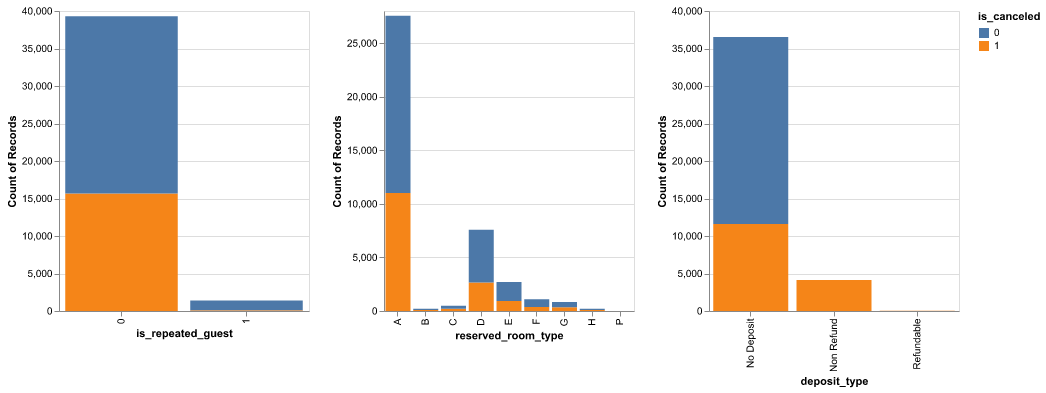

In [11]:
repeated_guest = alt.Chart(hotel_data_cleaned[['is_repeated_guest', 'deposit_type', 'reserved_room_type', 'is_canceled']]).mark_bar().encode(
    x='is_repeated_guest:N', 
    y='count()',
    color='is_canceled:N'
).properties(width=250)

deposit_type = alt.Chart(hotel_data_cleaned).mark_bar().encode(
    x='deposit_type:N',
    y='count()',
    color='is_canceled:N'
).properties(width=250)


room_type = alt.Chart(hotel_data_cleaned).mark_bar().encode(
    x='reserved_room_type:N',
    y='count()',
    color='is_canceled:N'
).properties(width=250)

repeated_guest | room_type | deposit_type

We can observe from the plots above that almost all cancellations are happening for new guests. Repeated guests who have booked with the hotel before do not seem to cancel much. In addition, the majoirty of cancellations occur for guests who have booked room type A. Interestingly, guests seem to cancel more when they have not provided a deposit on their booking and some also cancel when their deposit is non refundable.


## Preprocessing + Feature Transformations

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


In [13]:
X = hotel_data_cleaned.drop(columns=['is_canceled'])
y = hotel_data_cleaned["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

num_features = ["lead_time", "previous_cancellations", 'previous_bookings_not_canceled', 'booking_changes', 'total_of_special_requests']
cat_features = ["reserved_room_type", "deposit_type"]
binary_features = ['is_repeated_guest']

In [14]:
#defining transformers 
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore")

In [15]:
preprocessor = make_column_transformer(    
    (num_transformer, num_features),
    ("passthrough", binary_features),   
    (cat_transformer, cat_features)
)

## Training Models (Ashifa)

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Defining three models we are using to test 
knn = KNeighborsClassifier(n_neighbors=15)
dt = DecisionTreeClassifier(max_depth=6, random_state=123)
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=123)

# Building the pipelines
pipe_knn = make_pipeline(preprocessor, knn)
pipe_dt = make_pipeline(preprocessor, dt)
pipe_svm = make_pipeline(preprocessor, svm_rbf)

In [17]:
from sklearn.model_selection import cross_val_score

pipelines = {
    "KNN": pipe_knn,
    "DecisionTree": pipe_dt,
    "SVM_RBF": pipe_svm
}

cv_results = {}

#We are using 5-fold CV and comparing F1 scores 
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1")
    cv_results[name] = scores
    print(f"{name}: mean F1 = {scores.mean():.3f} ± {scores.std():.3f}")

KNN: mean F1 = 0.602 ± 0.009
DecisionTree: mean F1 = 0.572 ± 0.010
SVM_RBF: mean F1 = 0.526 ± 0.006


In [18]:
best_pipe = pipe_knn
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

In [20]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# Overall accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Test accuracy: 0.733
Confusion matrix:
 [[6453 1078]
 [2186 2490]]


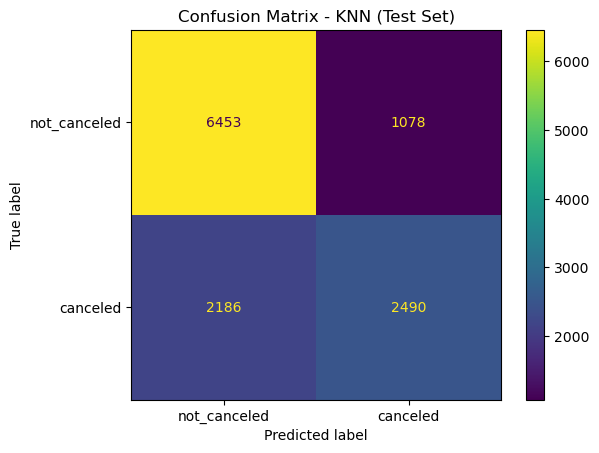

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_disp = ConfusionMatrixDisplay.from_estimator(
    best_pipe,          
    X_test,
    y_test,
    display_labels=["not_canceled", "canceled"],
    values_format="d"   
)

plt.title("Confusion Matrix - KNN (Test Set)")
plt.show()

- make pipeline with preprocessor + 2/3 models (KNN, Decision Tree, SVM RBF)
- carry out cv + compare scores to decide which model is best
- fit best model on training 
- score on test set
- generate confusion matrix (show precision/recall/f1 scores based on scores form the test set)
- another visualization idea: show ROC Curve, precision/recall curve.


# Discussion of Results (Athul)
Discussion of results above

# References